In [1]:
dataset_path = '/home/ycgao/Workdir/dataset/imagenet-mini/val'
qmodel_path = 'quantized.onnx'
model_path = 'origin.onnx'

In [2]:
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, PerChannelMinMaxObserver

from onnxutils.common import DatasetUtils
from onnxutils.quantization import symbolic_trace, ModuleQuantizer

from imagenet_pipeline import ImageNetPipeline

# Prepare

In [3]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

In [4]:
dataset = ImageNetPipeline.get_dataset(dataset_path)
torch_model = M()

# Quantization

In [5]:
graph_model = symbolic_trace(torch_model)
quantizer = ModuleQuantizer()

graph_model = quantizer.quantize(graph_model, [
    {
        'name': 'x',
        'activation': FakeQuantize.with_args(observer=HistogramObserver),
    },
    {
        'module_name': 'conv',
        'weight': FakeQuantize.with_args(observer=PerChannelMinMaxObserver),
    },
    {
        'module_name': 'relu',
        'activation': FakeQuantize.with_args(observer=HistogramObserver),
    },
])
graph_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        fq0 = self.fq0(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(fq0);  fq0 = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        bn = self.bn(conv);  conv = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(bn);  bn = None
        
        # No stacktrace found for following nodes
        fq1 = self.fq1(relu);  relu = None
        
         # File: /opt/miniconda3/lib/python3.10/site-p

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n        # No stacktrace found for following nodes\n        fq0 = self.fq0(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(fq0);  fq0 = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        bn = self.bn(conv);  conv = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(bn);  bn = None\n        \n        # No stacktrace found for following nodes\n        fq1 = self.fq1(relu);  relu = None\n        \n         # File: /opt/miniconda3/lib

# Finetune

In [6]:
dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2000
    ),
    batch_size=64
)
torch_model.to('cuda').eval()
graph_model.to('cuda').train()

loss_vals = []
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(graph_model.parameters(), lr=1e-5)
for _ in range(10):
    local_loss = 0
    for data in tqdm(dataloader):
        gt = torch_model(*data)
        pred = graph_model(*data)
    
        optimizer.zero_grad()
        loss = loss_fn(pred, gt)
        loss.backward()
        optimizer.step()

        local_loss += loss.detach().cpu().item()
    loss_vals.append(local_loss)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.93it/s]


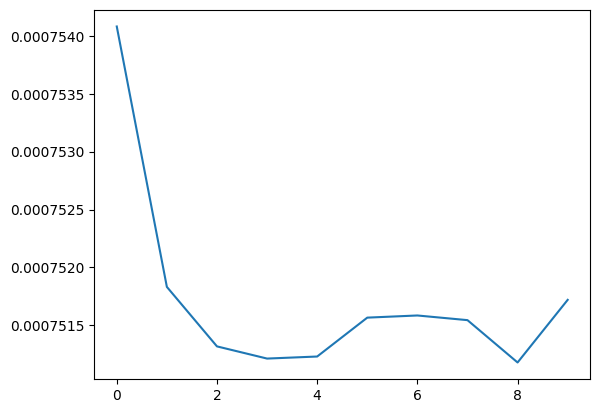

In [7]:
plt.plot(loss_vals)

# Eval

In [8]:
dataloader = DataLoader(
    DatasetUtils.drop_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2000
    ),
    batch_size=64
)
torch_model.to('cuda').eval()
graph_model.to('cuda').eval()

for data in dataloader:
    gt = torch_model(*data)
    pred = graph_model(*data)

    gt = gt.flatten(start_dim=1).float()
    pred = pred.flatten(start_dim=1).float()
    
    gt_max = gt.max(dim=1, keepdim=True)[0]
    gt_min = gt.min(dim=1, keepdim=True)[0]
    gt_range = gt_max - gt_min

    diff = torch.sqrt(torch.pow(gt - pred, 2)).max(dim=1, keepdim=True)[0]
    
    ret = torch.cat([diff, gt_max, gt_min, gt_range, diff / gt_range], dim=1)
    print(ret)
    break

tensor([[0.0418, 2.0151, 0.0000, 2.0151, 0.0207],
        [0.0338, 2.3111, 0.0000, 2.3111, 0.0146],
        [0.1417, 3.0094, 0.0000, 3.0094, 0.0471],
        [0.0400, 2.7675, 0.0000, 2.7675, 0.0144],
        [0.0583, 2.4683, 0.0000, 2.4683, 0.0236],
        [0.0402, 2.4573, 0.0000, 2.4573, 0.0164],
        [0.0475, 2.5253, 0.0000, 2.5253, 0.0188],
        [0.0887, 2.1774, 0.0000, 2.1774, 0.0407],
        [0.0461, 1.8306, 0.0000, 1.8306, 0.0252],
        [0.0381, 2.6665, 0.0000, 2.6665, 0.0143],
        [0.0360, 2.8793, 0.0000, 2.8793, 0.0125],
        [0.0344, 2.0263, 0.0000, 2.0263, 0.0170],
        [0.0357, 1.8881, 0.0000, 1.8881, 0.0189],
        [0.1012, 2.2852, 0.0000, 2.2852, 0.0443],
        [0.0400, 2.0962, 0.0000, 2.0962, 0.0191],
        [0.0404, 2.3073, 0.0000, 2.3073, 0.0175],
        [0.1462, 2.8827, 0.0000, 2.8827, 0.0507],
        [0.0408, 2.9631, 0.0000, 2.9631, 0.0138],
        [0.0413, 2.3654, 0.0000, 2.3654, 0.0175],
        [0.0402, 2.4693, 0.0000, 2.4693, 0.0163],


# Export

In [9]:
finalized_model = quantizer.finalize(graph_model)
finalized_model.to('cuda')

finalized_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
        # No stacktrace found for following nodes
        scale0 = self.scale0
        zero_point0 = self.zero_point0
        fake_quantize_per_tensor_affine = torch.fake_quantize_per_tensor_affine(x, scale0, zero_point0, 0, 255);  x = scale0 = zero_point0 = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(fake_quantize_per_tensor_affine);  fake_quantize_per_tensor_affine = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        bn = self.bn(conv);  conv = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTra

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n        # No stacktrace found for following nodes\n        scale0 = self.scale0\n        zero_point0 = self.zero_point0\n        fake_quantize_per_tensor_affine = torch.fake_quantize_per_tensor_affine(x, scale0, zero_point0, 0, 255);  x = scale0 = zero_point0 = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(fake_quantize_per_tensor_affine);  fake_quantize_per_tensor_affine = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        bn = self.bn(conv);  conv = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.jo

In [10]:
torch.onnx.export(
    finalized_model,
    tuple(next(iter(dataloader))),
    qmodel_path,
    input_names=['x'],
    output_names=['y'],
)
torch.onnx.export(
    torch_model,
    tuple(next(iter(dataloader))),
    model_path,
    input_names=['x'],
    output_names=['y'],
)